<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/pipelining_And_RandomForest/3_otto_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Last amended: 29th Sep, 2022
Myfolder: C:\\Users\\ashok\\OneDrive\\Documents\\xgboost\\otto
          /home/ashok/Documents/8.otto

Ref:
https://www.kaggle.com/alexpengxiao/preprocessing-model-averaging-by-xgb-lgb-1-39
https://joannaoyzl.github.io/2019/07/30/Tree-based-Model-in-Python/
https://www.kaggle.com/hsperr/finding-ensamble-weights

Objectives:
        i)   Using pandas, numpy and sklearn for modeling
        ii)  Feature engineering
                  a) Using polynomial features with interaction variables
       iii)  Feature selection
                  b) Using derived feature importance from modeling
                  c) Using sklearn FeatureSelection Classes
        iv)  Concept of log-loss
         v)  Classifciation using RandomForest, ExtraTreesClassifier
             LogisticRegression and VotingClassifier
        vi) Stacking models through probability wt optimization     


# IMPT NOTE:
# See also:
#   https://github.com/ModelOriented/DALEX
# For feature selection, also try MRMR package.
# As to what is MRMR technique, see this simple
# explanation:
# https://www.kaggle.com/getting-started/47791

Go through 'toy.py' first

""" 

###Call libraries
(#1--#1.11)

In [ ]:
# 1.0 Clear memory
#%reset -f

## A. Data manipulation

# 1.1 Call data manipulation libraries
import pandas as pd
import numpy as np


## B. Feature creation/manipulation

# 1.2 Feature creation Classes
#from sklearn.preprocessing import PolynomialFeatures   # Interaction features
#from sklearn.preprocessing import KBinsDiscretizer

# 1.2.1 BoxCox transformations:

from sklearn.preprocessing import PowerTransformer     # BoxCox transformation
from sklearn.preprocessing import QuantileTransformer
#from sklearn.preprocessing import KBinsDiscretizer    # Discretise continuous 
                                                       #   variable into K-bins

## C. Feature selection:

# 1.3 For feature selection
# Ref: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import  VarianceThreshold   # Remove constant-value columns

## D. Data preprocessing

# 1.4.1 Scaling data in various manner
from sklearn.preprocessing import StandardScaler


# 1.4.2 For encoding target class values
from sklearn.preprocessing import LabelEncoder

# 1.5 Splitting data
from sklearn.model_selection import train_test_split                # Returns split data
# 1.5.1
#from sklearn.model_selection import StratifiedShuffleSplit          # Returns data indicies

## E. Pipelining

# 1.6 Pipelines
from sklearn.pipeline import make_pipeline
#from sklearn.compose import ColumnTransformer

## F: Estimators:

# 1.7 Modeling
# 1.7.1
from sklearn.utils.class_weight import compute_class_weight

# 1.7.2
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# 1.8 Performance metrics
from sklearn.metrics import  confusion_matrix,log_loss

## G. Optimizer
# 1.9 scipy optimize
from scipy.optimize import minimize

## G: Others
# 1.10 Misc/visualization
import os, time, gc
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 1.11 Display multiple commands output from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Random Forest Classifier
How does it work?

#### Bootstrapping
Sampling with replacement

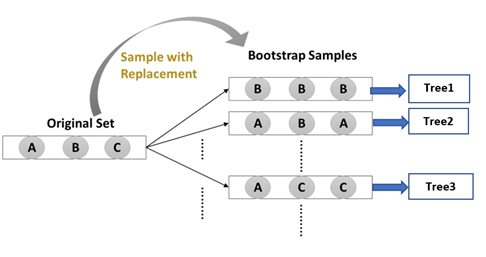

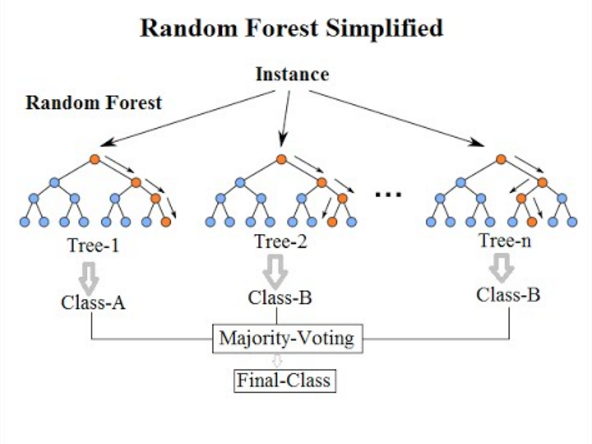

#### Out of Bag error (OOB):
The `RandomForestClassifier` is trained using bootstrap aggregation, where each new tree is fit from a bootstrap sample of the training observations. The `out-of-bag (OOB)` error is the average error for each calculated using predictions from the trees that do not contain OOB observations. This allows the RandomForestClassifier to be fit and validated whilst being trained.



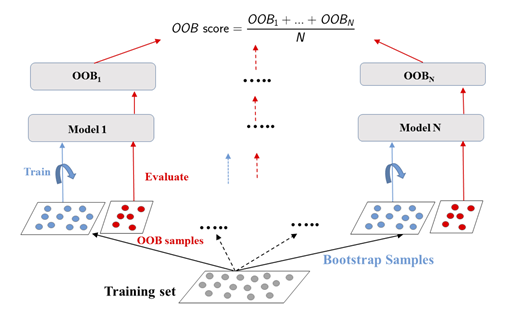

OOB error changes with the number of trees in the forest should be plotted. This plot would suggest that the model stabilizes after how many trees (say, roughly 100 trees). I generally use 500 or more trees, as it has been shown that <u>using more trees generally doesn’t reduce classification accuracy or cause overfitting</u>. However, more trees will make the model more computationally intensive. If you aren’t sure how many trees to build, you can use OOB error plot to assess the impact (see below).

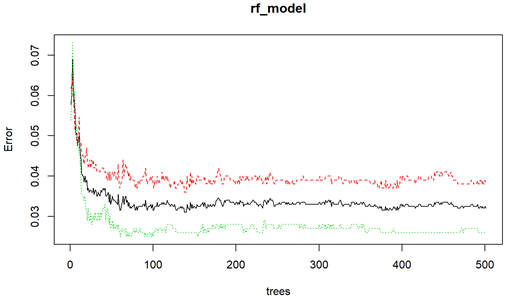

#### Feature importance calculation in Random Forest Classifier

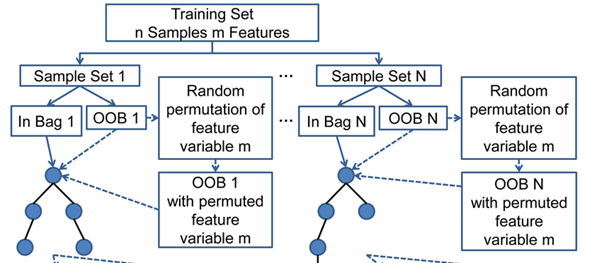

Note that random forest-based importance measures have been shown to be biased if the number of training samples in each class are not balanced and/or variables are highly correlated.   

Impurity in tree based models is quantified by the splitting criterion of the decision trees (Gini, Entropy or Mean Squared Error). However, this method can give high importance to features that may not be predictive on unseen data when the model is overfitting.  

sklearn's <u>Permutation-based feature importance</u>, on the other hand, avoids this issue, since it can be computed on unseen data.

Furthermore, impurity-based feature importance for trees are strongly biased and favor high cardinality features (typically numerical features) over low cardinality features such as binary features or categorical variables with a small number of possible categories.

Permutation-based feature importances do not exhibit such a bias. Additionally, the permutation feature importance may be computed performance metric on the model predictions predictions and can be used to analyze any model class (not just tree-based models). See this [link](https://scikit-learn.org/stable/modules/permutation_importance.html#relation-to-impurity-based-importance-in-trees).

###Bagging classifier

A bagging classifier is a more generalized version of RandomForest classifier. In RandomForest modeling our base estimator is a decision tree. In BaggingClassifier, we can have any Base Estimator, say, neural network.   

The porcess is, therefore, something like this: Create multiple bootstrap samples. Select a base estimator. To that base estimator, feed bootstrapped dataset with a subset of features and make predictions. Make similar predictions from a different bootstrapped sample and another subset of randomly selected features.   

Finally when all predictions have been made, make final predictions through voting (in case of classification) and through averaging (in case of regression).  

In sklearn, bagging classifier can be attempted through `BaggingClassifier` class. 

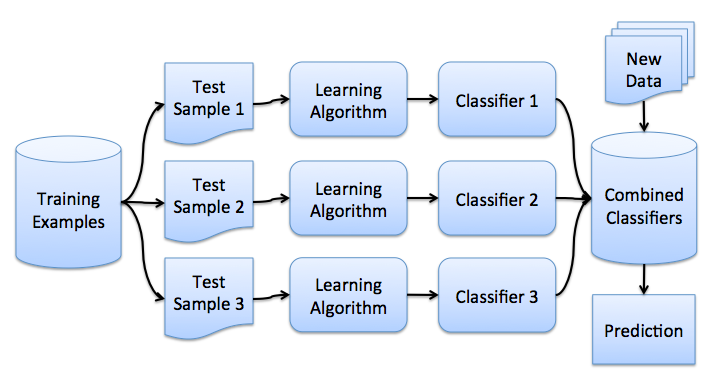

<i>Question</i>: Will the feature that is used to split at root-node be different for each tree?  

<i>Answer</i>: Yes. Read the following extract from [source code](https://github.com/scikit-learn/scikit-learn/blob/15a949460/sklearn/ensemble/_forest.py#L884) of `RandomForestClassifier` (lines 1414 to 1421).

```
The features are always randomly permuted at each split. 
Therefore, the best found split may vary, even with the
same training data, ``max_features=n_features`` and 
``bootstrap=False``, if the improvement of the criterion 
is identical for several splits enumerated during the 
search of the best split. To obtain a deterministic 
behaviour during fitting, ``random_state`` has to be fixed.
```

### Mount gdrive

In [ ]:
# Mount gdrive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Read data & reduce Memory
(#2--#2.11)

In [ ]:
# 2.0 Set datafile path
path = "D:\\data\\OneDrive\\Documents\\xgboost\\otto"
path = "/gdrive/MyDrive/Colab_data_files/otto/"
os.chdir(path)

In [ ]:
# 2.1 Read train file
train = pd.read_csv("train.csv.zip")

In [ ]:
# 2.2 Look at data
train.shape                        # 61878 X 95
print()
train.head(2)

(61878, 95)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1


In [ ]:
# 2.3 Target classes--absolute vs normalized
train.target.value_counts()
print("\n\n--normalized--\n")
train.target.value_counts(normalize=True)

Class_2    16122
Class_6    14135
Class_8     8464
Class_3     8004
Class_9     4955
Class_7     2839
Class_5     2739
Class_4     2691
Class_1     1929
Name: target, dtype: int64



--normalized--



Class_2    0.260545
Class_6    0.228433
Class_8    0.136785
Class_3    0.129351
Class_9    0.080077
Class_7    0.045881
Class_5    0.044265
Class_4    0.043489
Class_1    0.031174
Name: target, dtype: float64

In [ ]:
# 2.4  Check if there are Missing/duplicate values? None
train.isnull().sum()            # None
print("\n----------")
train.isnull().sum().sum()      # None
print("\n------------")
train.duplicated().sum()        # None

id         0
feat_1     0
feat_2     0
feat_3     0
feat_4     0
          ..
feat_90    0
feat_91    0
feat_92    0
feat_93    0
target     0
Length: 95, dtype: int64


----------


0


------------


0

In [ ]:
# 2.5 Drop 'id' and save target column in another variable:

train.drop(columns = ['id'] , inplace = True)
target = train.pop('target')   # Target

In [ ]:
# 2.6 Data is very skewed

train.describe()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
count,61878.00000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,...,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000
mean,0.38668,0.263066,0.901467,0.779081,0.071043,0.025696,0.193704,0.662433,1.011296,0.263906,...,0.070752,0.532306,1.128576,0.393549,0.874915,0.457772,0.812421,0.264941,0.380119,0.126135
std,1.52533,1.252073,2.934818,2.788005,0.438902,0.215333,1.030102,2.255770,3.474822,1.083340,...,1.151460,1.900438,2.681554,1.575455,2.115466,1.527385,4.597804,2.045646,0.982385,1.201720
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,61.00000,51.000000,64.000000,70.000000,19.000000,10.000000,38.000000,76.000000,43.000000,30.000000,...,76.000000,55.000000,65.000000,67.000000,30.000000,61.000000,130.000000,52.000000,19.000000,87.000000


### Decide if a feature is categorical
If a feature has less than 5 unique values, it is categorical

In [ ]:
# 2.7 Is there any case where number of unique values
#       in a column are less than 5:

(train.nunique() < 5).sum()

0

### Distribution of dtypes?
Can we reduce memory usage

In [ ]:
# 2.7.1

train.dtypes.value_counts()        # All features are integers except target

int64    93
dtype: int64

#### Reduce memory usage

In [ ]:
# 2.8 Reduce Memory usage
print("--Current memory usage (MB) --\n")
train.memory_usage().sum()//1000000  # 46.03736MB

# 2.9
print("\n\n--Max and min values---\n")
train.max().max()               # 352
print()
train.min().min()               # 0

# 2.10 Change dtype
train = train.astype('uint16')

# 2.11
print("\n\n--Revised memory usage (MB) --\n")
train.memory_usage().sum()//1000000  # 11.509436 MB

--Current memory usage (MB) --



46



--Max and min values---



352

0



--Revised memory usage (MB) --



11

### Process data
(#3--#3.2)  
Label encode target

#### Label encoding

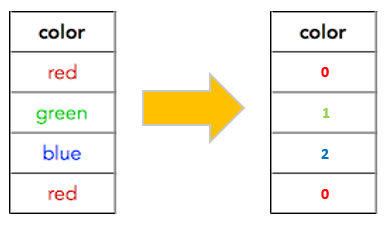

In [ ]:
# 3.0 Instantiate class
le = LabelEncoder()           # Instantiate LabelEncoder

# 3.0.1 Train object
le.fit(target)

# 3.0.2 Transform 'target'
y = le.transform(target)   # Fit and transform 'y'

# 3.0.3
y[:-20]

LabelEncoder()

array([0, 0, 0, ..., 8, 8, 8])

In [ ]:
# 3.1 How has transformation been done:

le.classes_   # These are in the order 0,1,2,....

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

In [ ]:
# 3.2 Which class is mapped to which digit?

dict(zip(le.classes_, le.transform(le.classes_)))

{'Class_1': 0,
 'Class_2': 1,
 'Class_3': 2,
 'Class_4': 3,
 'Class_5': 4,
 'Class_6': 5,
 'Class_7': 6,
 'Class_8': 7,
 'Class_9': 8}

## Part-I
Build a pipeline of operations, make predictions and evaluate pipe

### Plumbing
(#4.0--#6.3)  
>Without pipe<br>
Split->Compute class wts->Scale data->Build model-> Train model<br>
Using pipe  
Split->Compute class wts->Create Pipe->Train pipe<br>

#### Compute class weights

If parameter value of `balanced`, is given, then calculations are made as:

> `n_samples / (n_classes * np.bincount(y))`
 
For example if number of samples are 61878, and if `n_classes` are 9, and if number of value_counts() for `class_1` are 1929, then `class-weight` for this class will be:

`(61878/9)/ 1929 = 3. 5641`

Note, `np.bincount(y)` and `y.value_counts()` give same results. Less the number of samples (1929), more the class weight.

In [ ]:
# 4.0 How much importance be give nto a class?
weights = compute_class_weight(
                                'balanced',             # Alternative: dictionary
                                classes = np.unique(y), 
                                y=y
                               )

# 4.0.1 Class weights:

weights    # Corresponds to class_1, class_2, ...class_9

array([3.56419561, 0.4264566 , 0.85898717, 2.55493621, 2.51016186,
       0.48640491, 2.42174475, 0.81230309, 1.38755466])

In [ ]:
# 4.1 So how much weight each class has?

c_weights = dict(zip([0,1,2,3,4,5,6,7,8],weights))

# 4.2
c_weights

{0: 3.5641956108519093,
 1: 0.4264566017450275,
 2: 0.8589871730801266,
 3: 2.5549362071101203,
 4: 2.51016185955945,
 5: 0.4864049050819479,
 6: 2.4217447458025125,
 7: 0.8123030875866415,
 8: 1.3875546585940128}

#### Split data
Stratified splitting

##### Stratified sampling
From each strata or class, sample randomly

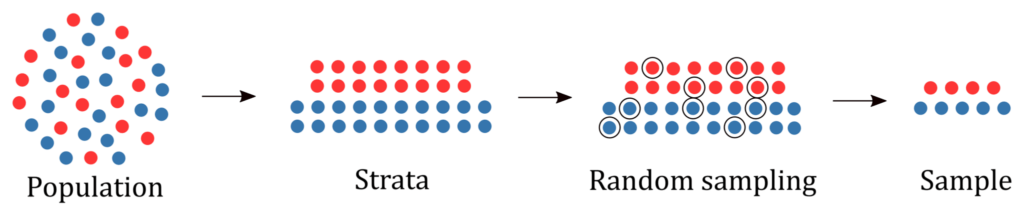

In [ ]:
# 4.3 Perform stratified sampling
X_train, X_test, y_train,y_test = train_test_split(
                                                   train,
                                                   y,
                                                   test_size = 0.3,
                                                   stratify = y,
                                                   shuffle= True)

#4.4
X_train.shape  # (43314, 93)
X_test.shape   # (18564, 93)

(43314, 93)

(18564, 93)

#### Model building
No pipelining

##### Scale data

In [ ]:
# 5.0 Instantiate Scaler class
ss = StandardScaler()

# 5.0.1 Train scaler object
ss.fit(X_train)

# 5.0.2 Transform train data
X_train = ss.transform(X_train)

# 5.0.3 Transform test data
X_test =  ss.transform(X_test)

StandardScaler()

##### Apply RandomForest estimator

In [ ]:
# 5.1 Instantiate RF class:

clf = rf(              
         n_estimators=100,
         max_depth = 35,
         class_weight = c_weights,
         oob_score = True   # Get OOB score also
         )

In [ ]:
# 5.2 Train the estimator:

clf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 3.5641956108519093,
                                     1: 0.4264566017450275,
                                     2: 0.8589871730801266,
                                     3: 2.5549362071101203, 4: 2.51016185955945,
                                     5: 0.4864049050819479,
                                     6: 2.4217447458025125,
                                     7: 0.8123030875866415,
                                     8: 1.3875546585940128},
                       max_depth=35, oob_score=True)

##### Make predictions

In [ ]:
# 5.3 Calculate probabilities of each observation 
#     falling into a class:

prob_clf = clf.predict_proba(X_test)

##### Calculate logloss

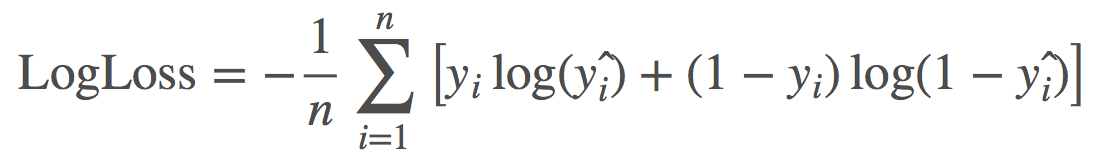

In [ ]:
# 5.4
log_loss(y_test,prob_clf) 

0.6062996122665321

#### Pipeline & model building
Build and use pipe1

In [ ]:
# 6.0 Our first pipe:
pipe1 = make_pipeline(
                      StandardScaler(),       # pipe1[0] Try other Scalers also
                      rf(                     # pipe1[1]
                          n_estimators=100,
                          max_depth = 35,
                          class_weight = c_weights,
                          oob_score = True   # Get OOB score also
                         )
                      )

In [ ]:
# 6.1 Train pipe1:

pipe1.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight={0: 3.5641956108519093,
                                                      1: 0.4264566017450275,
                                                      2: 0.8589871730801266,
                                                      3: 2.5549362071101203,
                                                      4: 2.51016185955945,
                                                      5: 0.4864049050819479,
                                                      6: 2.4217447458025125,
                                                      7: 0.8123030875866415,
                                                      8: 1.3875546585940128},
                                        max_depth=35, oob_score=True))])

In [ ]:
# 6.2 Make probability predictions:
#     https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba

prob_pipe1 = pipe1.predict_proba(X_test)
prob_pipe1.shape   # (18564, 9) There are 9 prob per observation

(18564, 9)

In [ ]:
# 6.2.1 Print probabilities
prob_pipe1

# 6.2.2 Look at probability values in the first row 
prob_pipe1[0,:]

# 6.2.3 Sum them up
prob_pipe1[0,:].sum()

# 6.2.4 And what are the classes
le.classes_

array([[2.73664041e-04, 2.33770685e-04, 8.88371044e-05, ...,
        3.06240795e-04, 1.85493012e-04, 3.34739894e-04],
       [1.02763266e-02, 3.81882628e-01, 3.54490880e-01, ...,
        2.31577657e-02, 1.40481104e-03, 1.86875980e-02],
       [5.00000000e-02, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e-02, 1.00000000e-02, 8.90000000e-01],
       ...,
       [7.09886757e-04, 3.99119967e-01, 4.70008322e-01, ...,
        3.43796261e-03, 2.37811071e-03, 1.27185096e-02],
       [1.11115462e-04, 9.08602094e-01, 6.05653678e-02, ...,
        6.18822990e-03, 7.79400463e-04, 1.15910593e-02],
       [3.57553731e-01, 1.09442975e-02, 6.05084115e-05, ...,
        9.04656401e-02, 2.60294950e-01, 1.00284070e-01]])

array([2.73664041e-04, 2.33770685e-04, 8.88371044e-05, 3.38518902e-04,
       9.98082449e-01, 1.56286528e-04, 3.06240795e-04, 1.85493012e-04,
       3.34739894e-04])

1.0

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

In [ ]:
# 6.3 Transform probability predictions to a DataFrame
class_names = ['class_1','class_2','class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']

pr = pd.DataFrame(prob_pipe1, columns = class_names)

pr.head()

,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,0.000274,0.000234,0.000089,0.000339,0.998082,0.000156,0.000306,0.000185,0.000335
1,0.010276,0.381883,0.354491,0.184705,0.005163,0.020232,0.023158,0.001405,0.018688
2,0.050000,0.000000,0.000000,0.000000,0.000000,0.040000,0.010000,0.010000,0.890000
3,0.107492,0.242569,0.042252,0.023373,0.015285,0.043010,0.051834,0.061374,0.412810
4,0.000000,0.936156,0.037657,0.024278,0.000000,0.000316,0.000544,0.001049,0.000000


### LogLoss
(#7.0)  
What is logloss?

Log Loss is the most important classification metric based on probabilities. The log loss is only defined for two or more labels. It's hard to interpret raw log-loss values, but log-loss is still a good metric for <u>comparing</u> models. For any given problem, a lower log-loss value means better predictions. Please see [here](https://www.kaggle.com/dansbecker/what-is-log-loss). Also see otto competition [evaluation](https://www.kaggle.com/c/otto-group-product-classification-challenge/overview/evaluation) process. Log loss is defined as below. Here there are M (=9) classes and  N observations. We have to calculate logloss for each one of the N observations and then take an average.

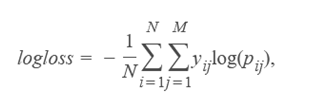

#### Here are two models
Which model is better-->Model1 or Model2?

```

Model 1
========

predicted prob | actual prob  | Accuracy?
q1    q2   q3  | p1 p2  p3    |
-----------------------------------------------
0.3  0.3  0.4  | 0  0   1     |  1
0.3  0.4  0.3  | 0  1   0     |  1
0.1  0.2  0.7  | 1  0   0     |  0

Model1:
accuracy: 2/3
```

```
Model 2
========

predicted prob | actual prob  | Accuracy?
q1    q2   q3  | p1 p2  p3    |
-----------------------------------------------
0.2  0.1  0.7  | 0  0   1     |  1
0.1  0.7  0.2  | 0  1   0     |  1
0.3  0.3  0.4  | 1  0   0     |  0

Model2:
	accuracy: 2/3
```

##### Logloss of the two *models*
Which model is better?

```
logloss_model1
     = -1/3( 1 * log(0.4) + 1 * log(0.4) + 1 * log(0.1))
     = 1/3(log(10/4) + log(10/4) + log(10/1))
```     

```	
logloss_model2
      = -1/3( 1 * log(0.7) + 1 * log(0.7)  + 1 * log(0.3))
	  = 1/3(log(10/7) + log(10/7) + log(10/3))
```    

#### Log loss plot

Actual probability is 1. As probability decreases, loss increases almost linearly but after some time as probability decreases even further, loss starts to decrease faster, and if probability decreases still further, loss decreases exponentially.

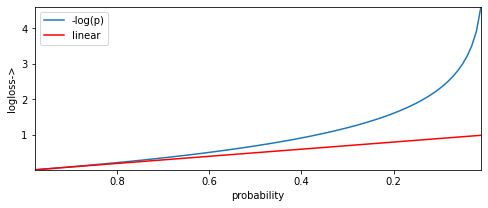

In [ ]:
# 7.0 Plot of p vs -log(p)

# https://stackoverflow.com/a/41481370
# prob = x * 0.01; Increases from 0.01 to 0.99
out = [(x * 0.01 , -np.log (x * 0.01)) for x in range(1,99)]
pr,loss = zip(*out)
fig = plt.figure(figsize = (8,3))
_=plt.plot(pr,loss, label = "-log(p)")
_=plt.plot(pr,1-np.array(pr), color = "red", label = "linear")
_=plt.axis([max(pr),min(pr),min(loss),max(loss)])
_=plt.xlabel("probability")
_=plt.ylabel("logloss->")
_=plt.legend()

### Log loss in otto case?
(#7.1--#7.4.1)  
And other model metrics

In [ ]:
# 7.1 How much is logloss for pipe1
#     https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html

log_loss(y_test,prob_pipe1)         # 0.602429785704475

0.6064334195248975

#### oob_score

In [ ]:
# 7.2 What is oob_score:
#     oob_score calculates accuracy.

pipe1[1].oob_score_   # 0.7969247818257377

0.7980560557787321

#### Decision function and logloss
See IInd comment below StackOverflow [here](https://datascience.stackexchange.com/a/30408/64849)
oob_score gives accuracy. <br> What if I want logloss? May use decision function, as:

oob_decision_function_ calculates the aggregate predicted probability for each data points across Trees when that data point is in the OOB sample of that particular Tree. See [here](https://datascience.stackexchange.com/a/88710/64849)

In [ ]:
# 7.2.1 Get class probabilities for the whole train dataset
#       but computed from oob_decision_function_ :
#       See https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#       And IInd comment below: 

pred_train_prob = pipe1[1].oob_decision_function_
pred_train_prob

In [ ]:
# 7.2.2 Calculate logloss based on oob_decision function:

log_loss(y_train, pred_train_prob)

0.677295096266196

### Feature importances

In [ ]:
# 7.3 Which features are more important?
#     The order of array values is as per
#     order of columns in train:

pipe1[1].feature_importances_

In [ ]:
# 7.4
# Plot features as per importance
# Ref: https://stackoverflow.com/a/613228/3282777

from operator import itemgetter
d = dict(zip(train.columns,pipe1[1].feature_importances_))
result = sorted(d.items(), key=itemgetter(1))
print(result)
cols = [i[0] for i in result]
print(cols)

[('feat_6', 0.0009758265228622876), ('feat_51', 0.0011436747579214185), ('feat_82', 0.0013894544258581762), ('feat_84', 0.0016940316198597169), ('feat_31', 0.0017735619882514736), ('feat_93', 0.002007406712978408), ('feat_28', 0.0021573243735757055), ('feat_5', 0.002426923645654263), ('feat_81', 0.0024411748099339202), ('feat_63', 0.0025100615449342623), ('feat_52', 0.0025154457231254933), ('feat_12', 0.0025915907823513707), ('feat_21', 0.002916709827162138), ('feat_49', 0.0033413516545088536), ('feat_2', 0.0033585609428738537), ('feat_65', 0.0038334333664727005), ('feat_7', 0.003957652788232059), ('feat_77', 0.004215248903877491), ('feat_19', 0.004242737414140691), ('feat_23', 0.004504240563503948), ('feat_29', 0.0045358307876712705), ('feat_10', 0.004581523523132465), ('feat_89', 0.004757274741120173), ('feat_74', 0.0051790599634270055), ('feat_73', 0.005321023083912808), ('feat_61', 0.005448014736704373), ('feat_55', 0.005700127242501482), ('feat_44', 0.005779928445520218), ('feat_8

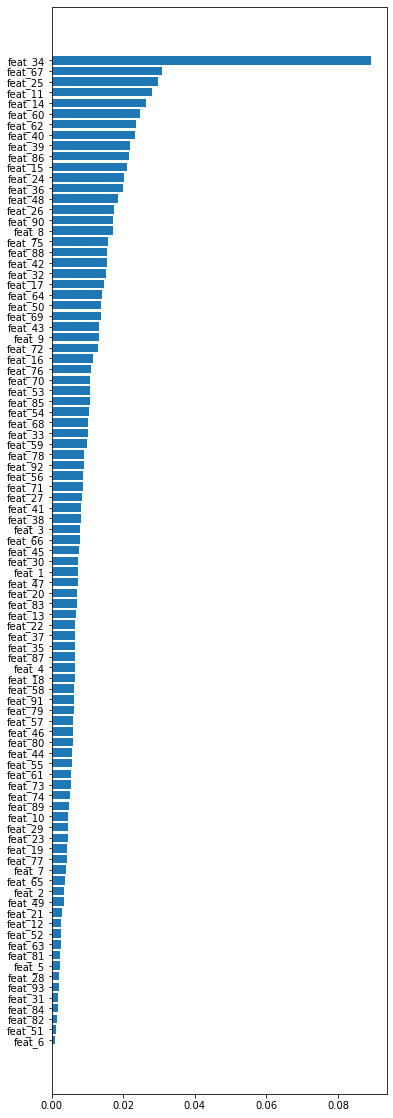

In [ ]:
# 7.4.1 Simple plot of feature importance
x,y = zip(*result)
fig = plt.figure(figsize = (6,20))
_=plt.barh(x,y)
plt.show()

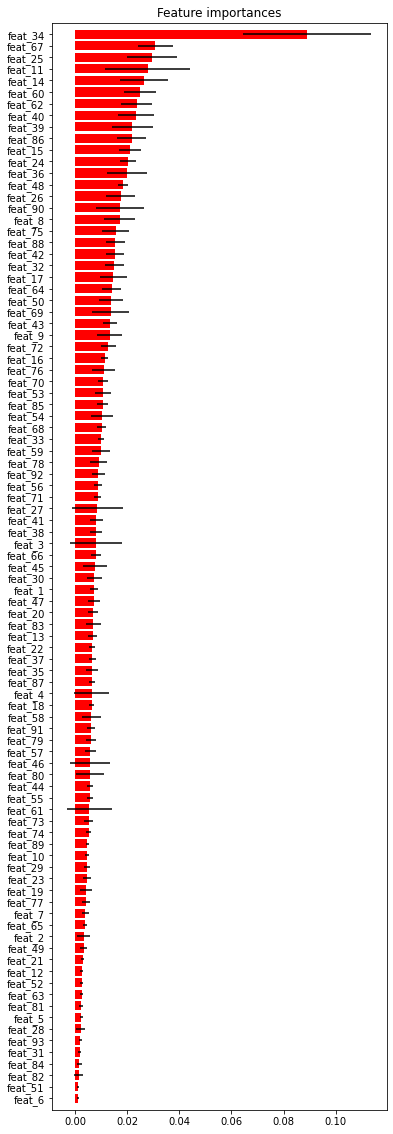

In [ ]:
# 7.4.2 Another feature imprtance plot but with error bars
# See: https://stackoverflow.com/a/44513347/3282777

# 7.4.3 Overall feature importance
importances = pipe1[1].feature_importances_ 

# 7.4.4 From each one of the n_trees decision trees in RF, calculate 
#       feature_importances and calculate their std deviation
#       The attribute 'pipe1[1].estimators_' has all the decision trees models

std = np.std(
             [tree.feature_importances_ for tree in pipe1[1].estimators_],
             axis=0
             )

# 7.4.5 indicies has indicies arranged in sorted order
indices = np.argsort(importances) 

# 7.4.6 Plot the feature importances of the RandomForest
fig = plt.figure(figsize = (6,20))
_=plt.title("Feature importances")
_=plt.barh(
           range(X_test.shape[1]),        # y-coordinates
           importances[indices],          # importances as per impt-value
           color="r",                     # colour
           xerr=std[indices],             # Error-bar plot
           align="center"                 # Align 
           )


# 7.4.7 If you want to define your own labels,
#        change indices to a list of labels on the following line.
_=plt.yticks(range(X_test.shape[1]), train.columns[indices])
_=plt.ylim([-1, X_test.shape[1]])
plt.show()

## Part II
Build more pipes and feed them to VotingClassifier

### pipe2
Uses `PowerTransformer()`

Why a log() transforms a right skewed distribuiton to a symmetrical distribution

A histogram is a plot of number of counts occurring at various points on X-axis. In a skewed histogram, higher count is appearing
near the point (x,y) = (0,0). When we take log
transformation of X-axis, the following happens:

Log stretches points near X-axis but compresses
points far away from X-axis. This affects density
of points. Density near origin is reduced while
density far away is increased.

Points near the X-axis (compratively) stretch out thus spreading data points to  a relatively longer region or frequency or counts, to say, in a larger portion. While points far away from X-axis, come closer together (thus displaying higher frequency).

log (0.1) = -1<br>
log (1)	  =  0<br>
log(10)   =  1<br>
log(100)  =  2<br>

Let original data point values be from 0 to 100. Let there be a large number of points between 0.1 and 10 and half the number of points between 10 to 100. So distribution is skewed. After log transfromation, number of points in the interval -1 to 1 will still be twice that of between the interval 1 to 2. But now distribution becomes uniform.

#### Example of `PowerTransformer`

In [ ]:
# 8.0 Generate a somewhat right skewed distribution:
#     https://stackoverflow.com/a/56552531/3282777

from scipy.stats import skewnorm
import matplotlib.pyplot as plt
maxValue = 10
numValues = 10000
skewness = 20   #Negative values are left skewed, positive values are right skewed.

x = skewnorm.rvs(a = skewness, loc=maxValue, size=numValues)  #Skewnorm function

x = (x - min(x))/ max(x) #Standadize all the vlues between 0 and 1. 
x = x * 100              #Multiply the standardized values by 100
x = x.reshape(-1,1)

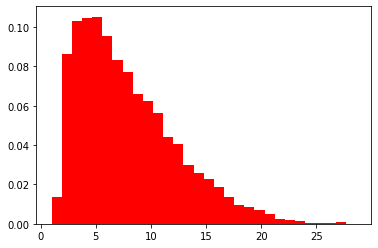

In [ ]:
# 8.1 Plot right skewed distribtion
#     Histogram with 30 bins:
bins = 30
_=plt.hist(x+1,bins,density=True, color = 'red')
plt.show()

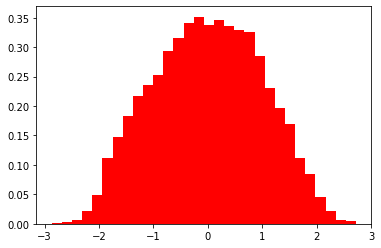

In [ ]:
# 8.2 Apply PowerTransformation to make it symmetrical
pt = PowerTransformer()
_=plt.hist(pt.fit_transform(x),bins,density=True, color = 'red')
plt.show()

#### Create pipe now

In [ ]:
# 9.0 Instantiate pipe
#     PowerTransform() data
pipe2 = make_pipeline(
                      StandardScaler(),
                      #QuantileTransformer(output_distribution='normal'),
                      PowerTransformer(),
                      rf(                    
                          n_estimators=100,
                          max_depth = 35,
                          class_weight = c_weights,
                          oob_score = True   # Get OOB score also
                         )
                       )

In [ ]:
# 9.1 Train pipe2 and make predictions:

# 9.1.1 Train and predict
pipe2.fit(X_train,y_train)
prob_pipe2 = pipe2.predict_proba(X_test)
prob_pipe2.shape   # (18564, 9)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('powertransformer', PowerTransformer()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight={0: 3.5641956108519093,
                                                      1: 0.4264566017450275,
                                                      2: 0.8589871730801266,
                                                      3: 2.5549362071101203,
                                                      4: 2.51016185955945,
                                                      5: 0.4864049050819479,
                                                      6: 2.4217447458025125,
                                                      7: 0.8123030875866415,
                                                      8: 1.3875546585940128},
                                        max_depth=35, oob_score=True))])

(18564, 9)

In [ ]:
# 9.2 How much is logloss
log_loss(y_test,prob_pipe2)         # 0.602429785704475

0.6099786585474523

In [ ]:
# 9.3
pipe2[2].oob_score_   # 0.7969247818257377

0.8022348432377522

#### Does powertransformer make any difference?
Draw histograms using pandas hist() function. <br>
See [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html)

<Figure size 1440x720 with 0 Axes>

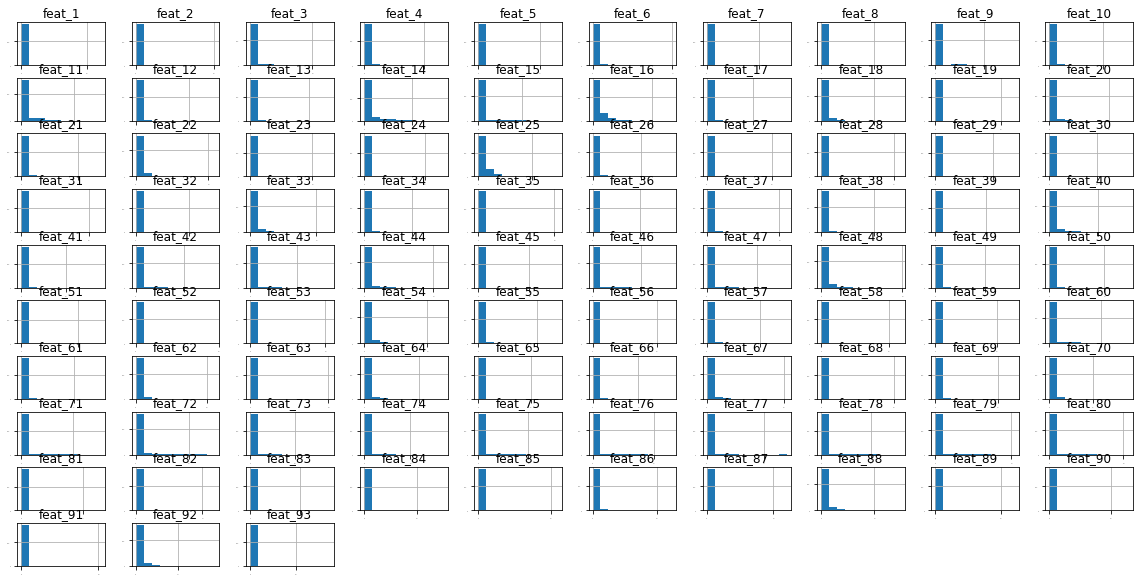

In [ ]:
# 9.4 Draw quick histograms of original data:
X_train.hist(
              figsize = (20,10),
              xlabelsize = 0,
              ylabelsize = 0
             )  ;

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


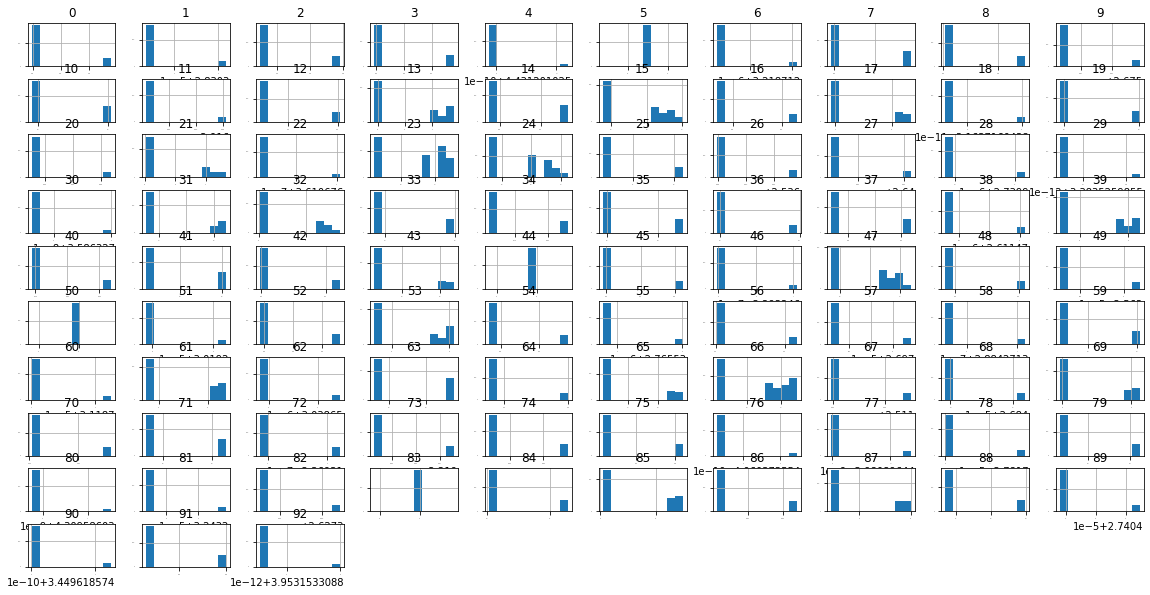

In [ ]:
# 9.5 Draw histograms of transformed data:

X_tr = pipe2[1].transform(X_train)         # Data Standardization
dataset = pipe2[1].transform(X_tr) ;       # powertransformation

# 9.6 Plot dataset now after making it a pandas DataFrame
pd.DataFrame(dataset).hist(figsize = (20,10), xlabelsize = 0, ylabelsize =0) ;

### pipe3
Uses ExtraTreesClassifier

#### What is ExtraTreesClassifier?
Ref kaggle [here](https://www.kaggle.com/hkapoor/random-forest-vs-extra-trees). The Classifier is much faster than `RandomForestClassfier` though each individual tree is deeper.



The "Random" in Random Forest is bceause we are using a random subset of the dataset. But what if instead of choosing the best possible threshold for each tree at each node, we simply choose a random threshold too. For example, if in Decision Trees, imagine the algorithm is not bothered to compute the passing score in the first attempt, instead it takes a random marks value which divides the dataset(let that random value be 90). Now at the first level, the students are divided into two categories (greater than and less than 90). If a student scores more than 90 he will be declared as pass, but if he scores less than 90, then the algorithm will find another random threshold (between 0 and 90) and categorize the remaining instances further. This algorithm too will eventually create an accurate model but it will have far more number of levels and nodes than a Decision Tree. However, the random nature of choosing the threshold value will make it much more faster.

In [ ]:
# 10.0 Instantiation
pipe3 = make_pipeline(
                       StandardScaler(),
                       ExtraTreesClassifier(n_estimators=300)
                      )

# 10.1 Train pipe and make predictions
pipe3.fit(X_train,y_train)
prob_pipe3 = pipe3.predict_proba(X_test)
prob_pipe3.shape   # (18564, 9)
print()
# 10.1.1 How much is logloss
log_loss(y_test,prob_pipe3)         # 0.602429785704475

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('extratreesclassifier',
                 ExtraTreesClassifier(n_estimators=300))])

(18564, 9)

0.5965798043192312

### pipe4

Experiment here with different data transformations

In [ ]:
# 10.4
# This pipe is for using different 
# transformations and seeing results:
# It is NOT used in VotingClassifier

pipe4 = make_pipeline(
                      QuantileTransformer(n_quantiles = 5),
                      RobustScaler(),
                      #PolynomialFeatures(degree =2,interaction_only=False),
                      #SelectKBest(k=200),
                      rf(                    
                          n_estimators=100,
                          max_depth = 35,
                          class_weight = c_weights,
                          oob_score = False
                         )
                       )

# 10.4.1
pipe4.fit(X_train,y_train)
prob_pipe4 = pipe4.predict_proba(X_test)
prob_pipe4.shape   # (18564, 9)
# How much is logloss
log_loss(y_test,prob_pipe4)         

In [ ]:
# 10.5
# Use another Estimator: LogisticRegression()

pipe5 = make_pipeline(
                      StandardScaler(),
                      LogisticRegression(
                                         max_iter = 8000,
                                         ),
                      )

pipe5.fit(X_train,y_train)
prob_pipe5 = pipe5.predict_proba(X_test)
prob_pipe5.shape   # (18564, 9)

# How much is logloss
print()
log_loss(y_test,prob_pipe5)   

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=8000))])

(18564, 9)

0.6443828350503915

### Voting Classifier
For details please see [here](http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)

The `VotingClassifier` is a meta-classifier for combining similar or conceptually different machine learning classifiers for classification via majority or plurality voting. (For simplicity, we will refer to both majority and plurality voting as majority voting.) 

The `VotingClassifier` implements "hard" and "soft" voting. In hard voting, we predict the final class label as the class label that has been predicted most frequently by the classification models. In soft voting, we predict the class labels by averaging the class-probabilities (only recommended if the classifiers are well-calibrated).

Voting classifiers require quite a lot of memory.

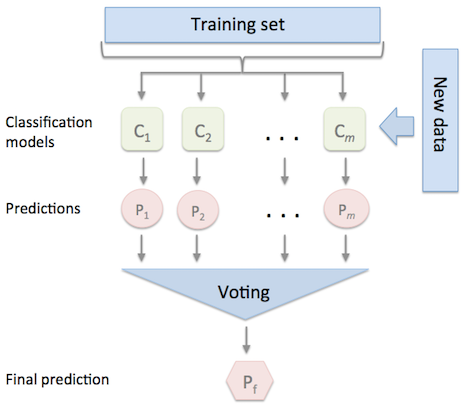

#### Workflow in Voting Classifier

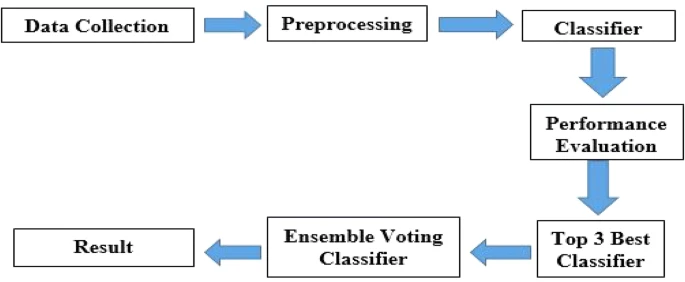

In [ ]:
# 11.0 Instantiate VotingClassifier:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

# 11.1 Estimators to use
estimators = [
               ("pipe1", pipe1),       # RandomForest
               ("pipe2", pipe2),       # With PowerTransfomer
               ("pipe3", pipe3),       # Extratreesclassifier
              ]

# 11.2 Instantiate VotingClassifier:
clf_vote = VotingClassifier(
                               estimators=estimators,
                               voting = "soft",
                               n_jobs = -1,
                               # weights=[0.28230404, 0.14546001, 0.57223595]    # ([0.28230404, 0.14546001, 0.57223595])
                            )

In [ ]:
# 11.3 fit and make predictions:

clf_vote.fit(X_train, y_train)
prob_vt = clf_vote.predict_proba(X_test)

# 11.4 logloss
print()
log_loss(y_test,prob_vt)        

VotingClassifier(estimators=[('pipe1',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(class_weight={0: 3.5641956108519093,
                                                                                    1: 0.4264566017450275,
                                                                                    2: 0.8589871730801266,
                                                                                    3: 2.5549362071101203,
                                                                                    4: 2.51016185955945,
                                                                                    5: 0.4864049050819479,
                                                                                    6: 2.4217447458025125,
          

0.5952015895177065

### Average probabilties through optimization
Calculate weighted average of probabilities to make final probability predictions.

#### How it works?

```
Once you have calculated probability predictions
of the nine classes through different models, you 
can add up probabilities of models in a weighted
manner to determine final probabilities and logloss.
Here is an example.

Let us say there are three classes. Here are the
probability predictions for one observation of test
set from three different models:

class1     class2       class3
0.2        0.4           0.4   =>       Model1
0.6        0.2           0.2   =>       Model2
0.1        0.7           0.2   =>       Model3

Final probability predictions for the three classes
are then calculated, as:

class1:   w1 * 0.2   + w2 * 0.6  +  w3 * 0.1
class2:   w1 * 0.4   + w2 * 0,2  +  w3 * 0.2
class3:   w1 * 0.4   + w2 * 0.2  +  w3 * 0.2

Let us say, for some initial w1,w2,w3 the three
probabilities from Ist test obs form an array of 
three values, prob_class[0,3]. For second, obs 
using the same set of weights, we get a similar 
array, prob_class[1,3] and so on. 

We then calculate overall log_loss (ie error), as:

         log_loss(y_test, prob_class)
         where both y_test and prob_class
         have shape: (n_test_samples,3)

scipy optimize module then tries to move w1, w2 and w3 in
the direction such that next calculation of error (log_loss)
gives (hopefully) better results.

```

#### Explaining scipy optimization
Refer [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) and [here](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html)

To use scipy optimize module, we have to clearly specify objective, constraints and bounds of variables. (Equality constraint means that the constraint function result is to be zero whereas inequality means that it is to be non-negative. )

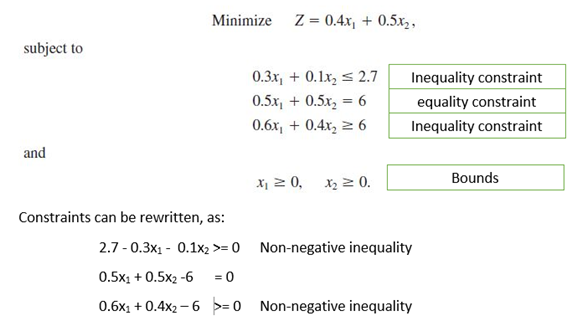

In [ ]:
# 12.0 This video explains scipy optimization process
#      in a very easy manner:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/cXHvC_FGx24?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

#### Now optimize with our models

##### First collect our models at one place

In [ ]:
# 12.1
clfs = []
clfs.append(pipe1)
clfs.append(pipe2)
clfs.append(pipe3)
#clfs.append(pipe4)
#clfs.append(pipe5)

##### Then use these models to make predictions




In [ ]:
# 12.2
predictions = []
for clf in clfs:
    predictions.append(clf.predict_proba(X_test))

# 12.3
print("\n--Predictions from how many models?---\n")
len(predictions)

# 12.4
print("\n\n--Shape of each prediction array--\n")
predictions[0].shape    # (18564, 9)

# 12.5
print("\n\n--First three proba rows--\n")
np.round(predictions[0][:3,:],3)   

# 12.6
print("\n\n---How many sets of predictions?------")
len(predictions)


--Predictions from how many models?---



3



--Shape of each prediction array--



(18564, 9)



--First three proba rows--



array([[0.03 , 0.01 , 0.   , 0.   , 0.   , 0.87 , 0.05 , 0.03 , 0.01 ],
       [0.02 , 0.09 , 0.02 , 0.   , 0.06 , 0.081, 0.599, 0.06 , 0.07 ],
       [0.   , 0.447, 0.254, 0.261, 0.009, 0.005, 0.013, 0.004, 0.006]])



---How many sets of predictions?------


3

##### Formulate objective and constraints

We have to specify:  
> a. Objective function<br>
> b. Any constraints on weights<br>
> c. Any bounds on weights<br>
> d. Some initial wt values
> e. Use (a) to (d) in an optimizer to determine optimum wts
> f. Repeat (d) and (e) multiple times to make sure that one is not stuck at local optima.


Objective function<br>
Very briefly this is what objective function does. <br>
Makes multiplication and then calculates logloss.

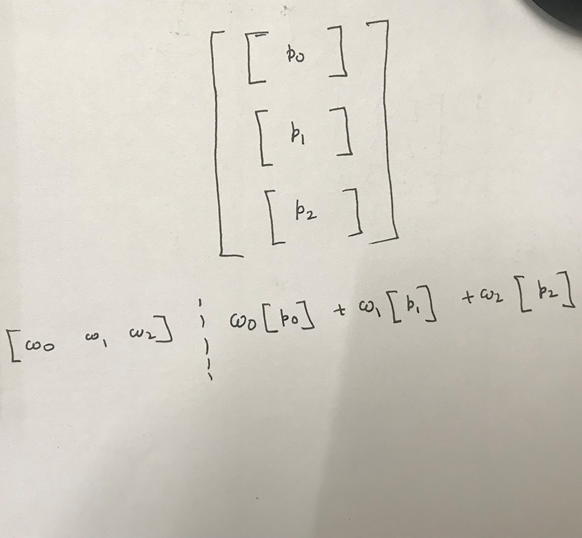

In [ ]:
## 13.0 Objective function:

def objective_func(weights):
    ''' Calculates row-by-row predictions
        by multiplying each one by corresponding weight.
        scipy minimize will pass the weights as a 1D numpy array '''

    final_prediction = 0 # Initialized as a scalar
    
    # predictions: (18564, 9)
    # weights: A list of three weights 
    for weight, prediction in zip(weights, predictions):
            # final_prediction is an array
            final_prediction += weight*prediction
            
    return log_loss(y_test, final_prediction)

weights must some to 1 as we are concerned with relative weights. 

In [ ]:
## 13.1 Constraints on weight values:

# One constraint is sum of all weights
# should be one. That is:
# np.sum(w) = 1
# OR np.sum(w) - 1 =0
# Define a function accordingly:

def const_f(weights):
  ''' scipy minimize will pass the weights as a numpy array '''
  
  return np.sum(weights) -1  


In [ ]:
# 13.1.1 Constraints definition:

# Once our constraint function is defined, we need
# to describe it more fully. That is should const(w)
# finally 'equal' zero or not. The dictioary helps
# to pass on to const() any other parameters, if needed.
# cons is a tuple of constraint definitions

cons = (
         {'type':'eq',     # So 'equality' constraint
          'fun': const_f   # And constraint function is const()
         }
       )

Also all weights must be positive and less than 1

In [ ]:
## 13.2 Bounds of weight-values:

#our weights are bound between 0 and 1

bounds = [(0,1)]*len(predictions)  # Same as: [(0,1), (0,1), (0,1)]

In [ ]:
## 13.3 Initial wt values

# The algorithm needs some starting wt-values. 
# We select randomly even though sum of these wts
#  is not one:
# 
# Generally, it is better to select many random starting
#  points and run minimize a few times to see which one of the 
#   wt combinations gives best results:

starting_wt_values = np.random.rand(len(predictions))  # 
starting_wt_values

array([0.38564969, 0.70310132, 0.22015398])

##### Finally apply optimization

In [ ]:
# help(minimize)

In [ ]:
## 13.4 Begin optimization process:

res = minimize(
                  fun=objective_func,     # To minimize what?
                  bounds=bounds,          
                  constraints=cons,       # Our dictionary
                  x0 =starting_wt_values,
                  method='SLSQP',
               )

In [ ]:
# 13.5 
# We get our best log-loss through:  res['fun']
# Best log loss

res['fun']


0.590773400613593

In [ ]:
# 13.6 Best set of wts:

res['x']


array([0.33969223, 0.17718738, 0.48312039])

###PowerTransformer

### How should otto data be scaled?
PowerTranformer() and boxplots

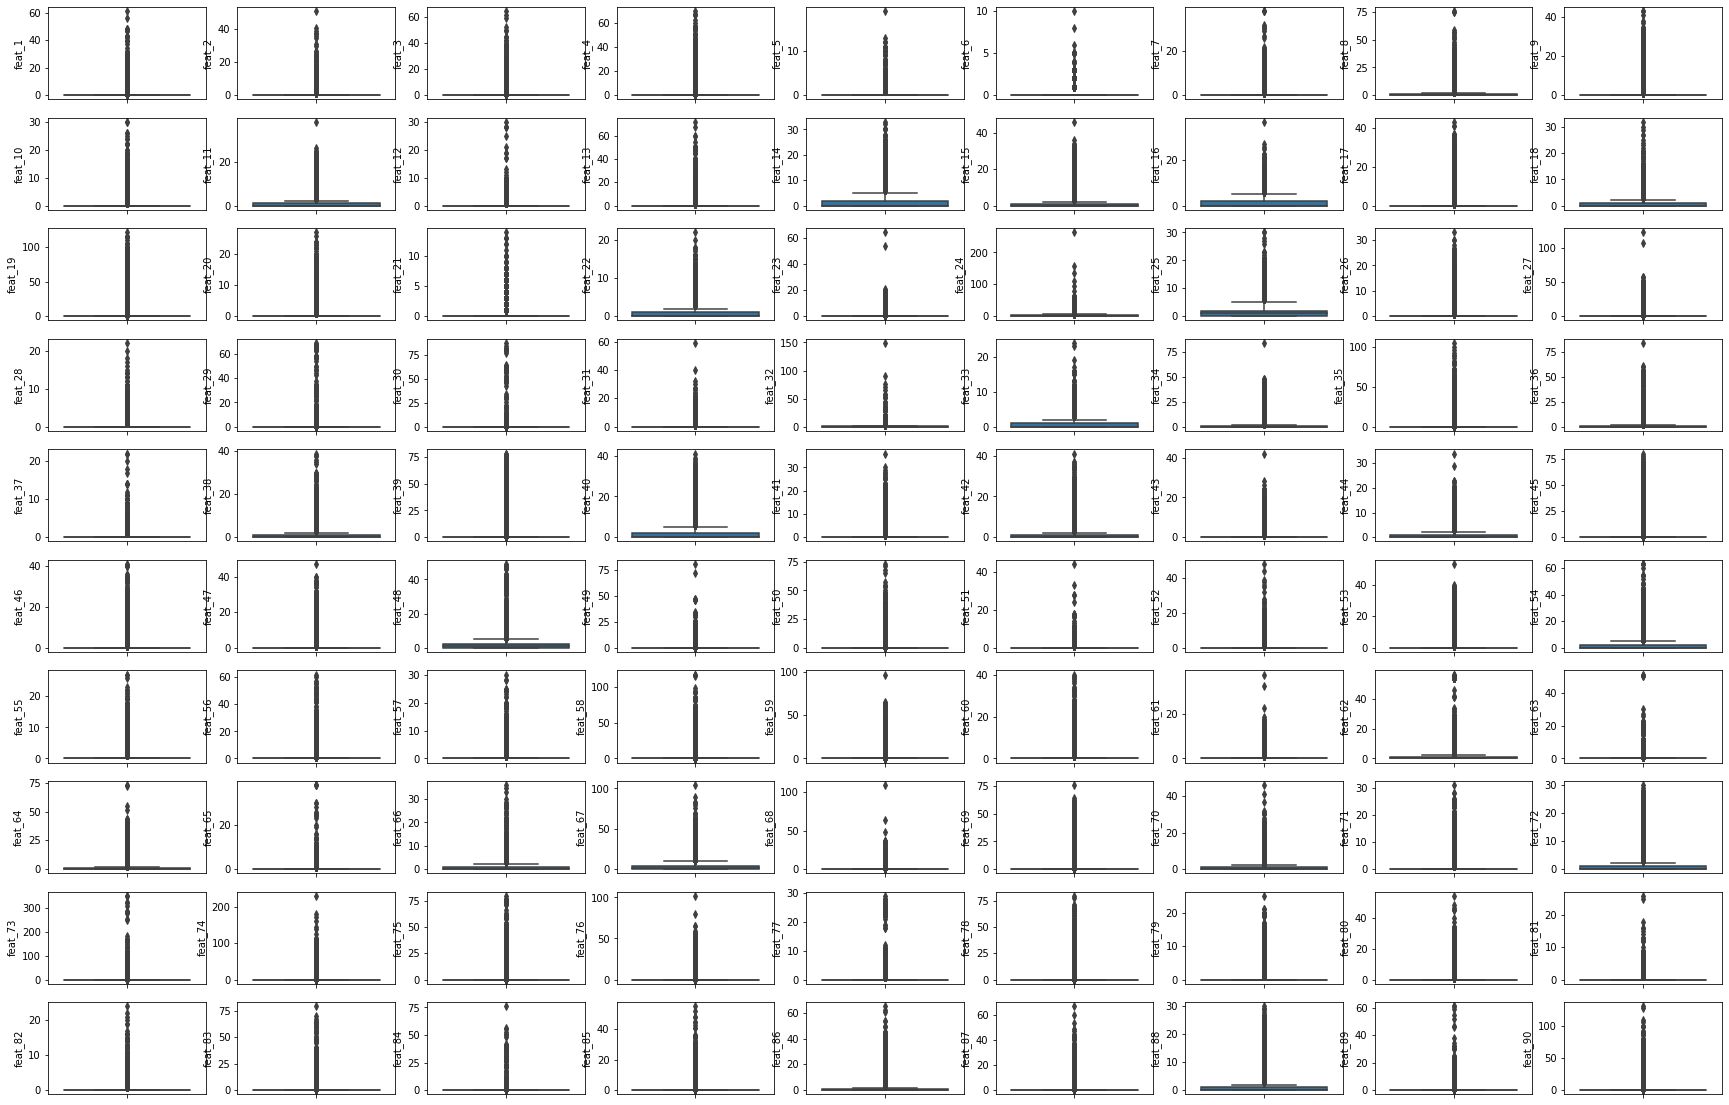

In [ ]:
# 14.0 How should we scale data?
#      Let us draw box-plots to decide
#      There are a number of outliers
#      in every feature:

fig = plt.figure(figsize=(30,20))
for i in range(0,90):
    name = 'feat_' + str(i+1)
    _=plt.subplot(10,9,i+1)
    _=sns.boxplot(y = train[name])


In [ ]:
# 14.1 PowerTransform every feature:

pt = PowerTransformer(method='yeo-johnson')
#rs = RobustScaler()
x_train = pt.fit_transform(train)
#x_train = rs.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns = train.columns)

In [ ]:
# 14.2 IS data still skewed?
#      Except in some places, it is still skewed
x_train.describe()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,...,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
count,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,...,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000
mean,0.449314,0.353109,0.504266,0.525630,0.224578,0.138705,0.310309,0.282682,0.490675,0.376517,0.316586,0.343660,0.476368,0.456293,0.334934,0.492878,0.442425,0.305820,0.320253,0.511338,0.366688,0.380069,0.276949,0.037355,-0.158212,0.507773,0.413831,0.381703,0.367340,0.294131,0.281355,0.379625,0.396753,0.271040,0.535937,0.265130,0.449417,0.273229,0.392874,0.476220,...,0.491022,0.474409,0.363048,0.418513,0.394543,0.351254,0.573147,0.321693,0.530894,0.328439,0.410449,0.417158,0.300243,0.036494,0.405387,0.404522,0.403687,0.449073,0.315782,0.448168,0.486072,0.523004,0.524833,0.245744,0.336800,0.362334,0.522858,0.232872,0.310341,0.391109,0.153422,0.514540,0.495693,0.490919,0.363976,0.531266,0.394530,0.291561,0.530411,0.253849
std,1.000008,1.000008,1.000008,1.000008,1.000008,1.000008,1.000008,0.468721,1.000008,1.000008,0.522856,1.000008,1.000008,0.536249,0.525963,0.531244,1.000008,0.481946,1.000008,1.000008,1.000008,0.534867,1.000008,0.521657,0.534258,1.000008,1.000008,1.000008,1.000008,1.000008,1.000008,0.557504,0.537722,0.466510,1.000008,0.459158,1.000008,0.461739,1.000008,0.529264,...,0.563196,1.000008,1.000008,1.000008,1.000008,1.000008,1.000008,1.000008,0.633137,1.000008,0.567118,1.000008,0.478954,0.494447,1.000008,1.000008,0.557594,1.000008,0.498371,1.000008,1.000008,1.000008,1.000008,1.000008,1.000008,1.000008,1.000008,1.000008,1.000008,1.000008,1.000008,1.000008,0.610541,1.000008,0.531194,1.000008,1.000008,1.000008,1.000008,1.000008
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.572004,-0.712024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.513304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

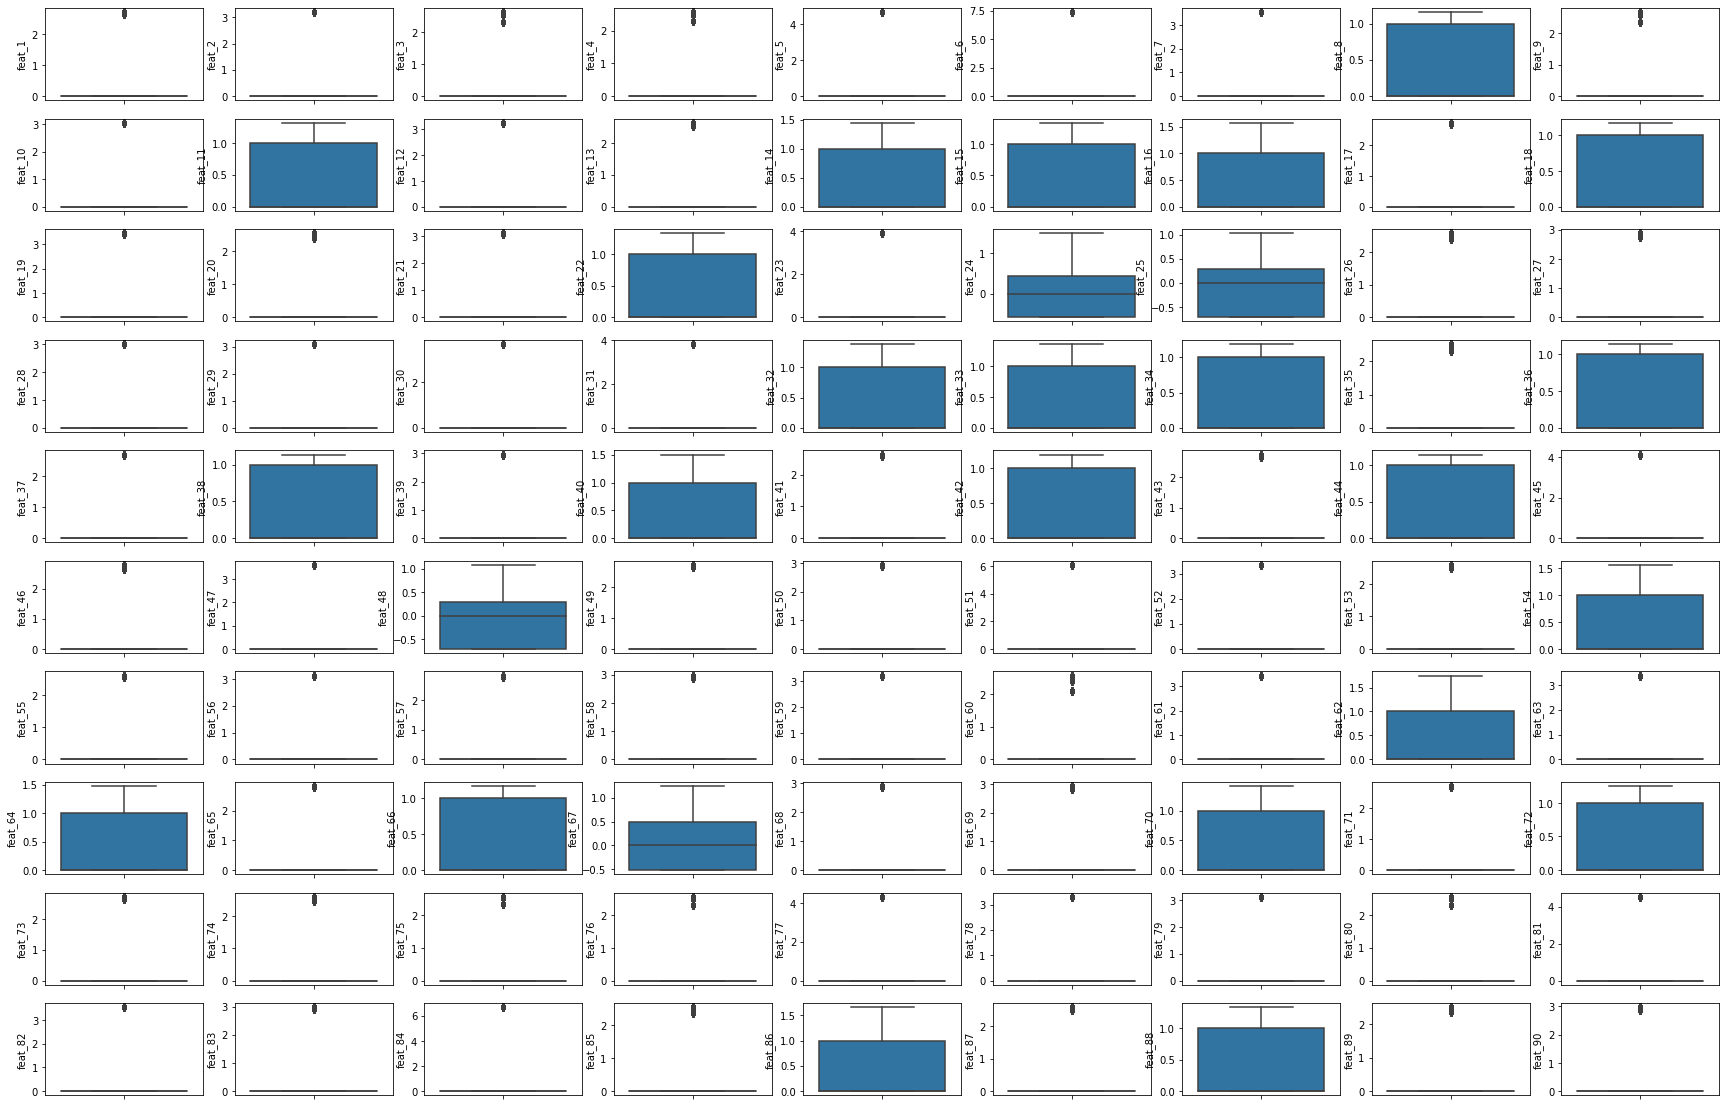

In [ ]:
# 14.3 Plot boxplots of transformed 
#      features

fig = plt.figure(figsize=(30,20))
for i in range(0,90):
    name = 'feat_' + str(i+1)
    _=plt.subplot(10,9,i+1)
    _=sns.boxplot(y = x_train[name])

In [ ]:
# 14.4 These columns are fully transformed:
colsToTransf = ["feat_8","feat_11","feat_14","feat_15","feat_16","feat_18","feat_22","feat_24","feat_25","feat_32","feat_33","feat_34","feat_36","feat_38","feat_40","feat_42","feat_44","feat_48","feat_54","feat_62","feat_64","feat_66","feat_67","feat_70","feat_72","feat_86","feat_87"]
colsToTransf = [7,10,13,14,15,17,21,23,24,31,32,33,35,37,39,41,43,47,53,61,63,65,66,69,71,85,
                86]


In [ ]:
############## I am done #################

### Pipes

In [ ]:
pipe1 = make_pipeline(StandardScaler(), PowerTransformer(), rf(max_depth =30))
pipe2 = make_pipeline(StandardScaler(), rf(max_depth =30))
#pipe3 = make_pipeline(StandardScaler(), ExtraTreesClassifier(n_estimators=300, max_depth =30))
#pipe4 = make_pipeline(StandardScaler(), PowerTransformer(), GaussianNB())
pipe5 = make_pipeline(StandardScaler(), LogisticRegression( multi_class="multinomial", max_iter = 8000))
pipe3 = make_pipeline(StandardScaler(), PolynomialFeatures(2,interaction_only=False, include_bias = False),VarianceThreshold(), ExtraTreesClassifier(n_estimators=300, max_depth =30))
pipe4 = make_pipeline(StandardScaler(), PolynomialFeatures(2,interaction_only=False, include_bias = False), VarianceThreshold(),SelectKBest(k=200),  rf())


In [ ]:
confusion_matrix(test['target'],test['pred'])

array([[ 265,   30,    1,    1,    3,   45,   11,  100,  123],
       [   2, 4315,  435,   24,    8,   14,   22,    7,   10],
       [   2, 1266, 1077,   23,    0,    3,   14,   11,    5],
       [   1,  352,  110,  306,    3,   30,    5,    0,    0],
       [   4,   20,    0,    0,  797,    1,    0,    0,    0],
       [  13,   48,    4,    7,    1, 4022,   40,   67,   39],
       [  16,  115,   64,    3,    7,   81,  456,   99,   11],
       [  24,   25,    8,    0,    1,   69,   11, 2362,   39],
       [  38,   40,    1,    0,    3,   45,    5,   54, 1300]])

In [ ]:
############# I am done #################